In [1]:
using SparseArrays, LinearAlgebra, ArnoldiMethod
using LsqFit
using LaTeXStrings
using Plots
using Statistics
using ProgressMeter

id = [1 0; 0 1] |> sparse
sx = [0 1; 1 0] |> sparse
sz = [1 0; 0 -1] |> sparse;

In [2]:
function build_HA(ns, Szi, A=50; bar=false)
    N = 4 + 3*(ns - 1)
    
    Abar = 0
    Bbar = 0
    
    Heff = zeros(N+1, N+1)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[ns+1])
    Ht = A/4 * (2*IdN + 2*Szi[N]*Szi[2*ns+1])
    
    Heff[2, ns+2] += 2
    Heff[2*ns+2, N+1] += 2
    
    Abar += 6/N - 2
    
    Hij = spzeros(Int, 2^N, 2^N)
    
    # source and tagert horizontal edges
    Hij += IdN - Szi[1]*(Szi[2] + Szi[ns+2]) - 2*Szi[1]
    Hij += IdN - Szi[N]*(Szi[2*ns] + Szi[N-1]) - 2*Szi[N]
    
    Heff[2, 3] += -1
    Heff[2, ns+3] += -1
    Heff[1, 2] += -2
    
    Heff[2*ns+1, N+1] += -1
    Heff[N, N+1] += -1
    Heff[1, N+1] += -2

    # horizontal corner edges
    Hij += 2*IdN + Szi[ns]*(Szi[2*ns] - Szi[ns-1] - Szi[2*ns+1]) + 2*Szi[ns]
    Hij += 2*IdN + Szi[2*ns+2]*(Szi[ns+2] - Szi[2*ns+3] - Szi[ns+1]) + 2*Szi[2*ns+2]
    
    Heff[ns+1, 2*ns+1] += 1
    Heff[ns, ns+1] += -1
    Heff[ns+1, 2*ns+2] += -1
    Heff[1, ns+1] += 2
    
    Heff[ns+3, 2*ns+3] += 1
    Heff[2*ns+3, 2*ns+4] += -1
    Heff[ns+2, 2*ns+3] += -1
    Heff[1, 2*ns+3] += 2
    
    # vertical corner edges
    Hij += IdN - Szi[ns+1]*Szi[2*ns+2]
    Hij += IdN - Szi[2*ns+1]*Szi[ns]
    
    Heff[ns+2, 2*ns+3] += -1
    Heff[ns+1, 2*ns+2] += -1
    
    Abar += -8/N - 8
    Bbar = 0
    
    # lower horizontal internal edges
    for i in 2:ns-1
        Hij += 2*IdN + Szi[i]*(Szi[i+ns] - Szi[i-1] - Szi[i+ns+1] - Szi[i+1])
        
        Abar += -2
        
        Heff[i+1, i+1+ns] += 1
        Heff[i, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[i+1, i+2] += -1
    end
    # vertical internal edges
    for i in ns+2:2*ns
        Hij += 4*IdN + Szi[i]*(Szi[i-ns] + Szi[i+ns] - Szi[i-ns-1] - Szi[i+ns+1]) + 4*Szi[i]
        
        Abar += 4/N - 4
        Bbar += 4
        
        Heff[i+1-ns, i+1] += 1
        Heff[i+1, i+1+ns] += 1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[1, i+1] += 4
    end
    # higher horizontal internal edges
    for i in 2*ns+3:N-1
        Hij += 2*IdN + Szi[i]*(Szi[i-ns] - Szi[i-1] - Szi[i-ns-1] - Szi[i+1])
        
        Abar += -2
        
        Heff[i+1-ns, i+1] += 1
        Heff[i, i+1] += -1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+2] += -1
    end

    Abar = A/4 * Abar
    Bbar = A/4 * Bbar
    
    Heff = A/4 * Heff
    Heff = Heff .+ transpose(Heff)
    
    Hij = A/4 * Hij
    HA = Hs + Ht + Hij
    
    if bar
        return HA, Heff, Abar, Bbar
    end

    HA, Heff
end


function build_HB(ns, Szi, W, B=1)
    N = 4 + 3*(ns - 1)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    HB = B / 2 * sum(W) * IdN
    for i in 1:N
        HB += B / 2 * W[i] * Szi[i]
    end

    HB
end


function build_Hx(ns)
    N = 4 + 3*(ns - 1)
    
    # vector of operators: [sx, id, ...]
    Sx_list = fill(id, N)
    Sx_list[1] = sx

    HX = spzeros(Int, 2^N, 2^N)
    for i in 1:N
        HX -= foldl(kron, Sx_list)
        Sx_list = circshift(Sx_list, 1)
    end
    HX
end;

In [3]:
function eigs(x; nev=2)
    decomp, history = partialschur(x, nev=nev, which=SR())
    e, v = partialeigen(decomp)
    e, v
end


function compute_dH(v1, v2, Szi)
    
    N = trunc(Int, log2(size(v1, 1)))
    
    v1 = round.(v1)
    v2 = round.(v2)
    
    v1z = zeros(N)
    v2z = zeros(N)
    
    for i in 1:N
        v1z[i] = v1' * Szi[i] * v1
        v2z[i] = v2' * Szi[i] * v2
    end

    sum(abs.(v2z .- v1z)) / 2
end;

In [4]:
ns = 1
N = 4

A = 50
B = 1

IdN = sparse(1.0I, 2^N, 2^N)
    
# vector of operators: [sz, id, id, ...]
Sz_list = fill(id, N)
Sz_list[1] = sz

Szi = fill(IdN, N)
for i in 1:N
    Szi[i] = foldl(kron, Sz_list)
    # cyclic shift the operators
    Sz_list = circshift(Sz_list, 1)
end

Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[2])
Ht = A/4 * (2*IdN + 2*Szi[3]*Szi[4])

Hij = A/4 * (2*IdN - 2*Szi[1]*Szi[3])
Hij += A/4 * (2*IdN - 2*Szi[2]*Szi[4])

HA1 = Hs + Ht + Hij

Heff1 = zeros(N+1, N+1)
Heff1[2, 3] = A/2
Heff1[4, 5] = A/2
Heff1[2, 4] = -A/2
Heff1[3, 5] = -A/2

Heff1 = Heff1 + transpose(Heff1);

In [ ]:
Ms = [10000, 10000, 10000, 10000, 1000, 1000, 100]

ns_max = 4

# critical S
Sc = zeros(ns_max, 2)
# minimum gap
Dmin = zeros(ns_max, 2)

Dmin_p = zeros(ns_max, 2)

for ns in 1:ns_max
    N = 4 + 3*(ns - 1)
    M = Ms[ns]
    W = rand(N, M)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    # vector of operators: [sz, id, id, ...]
    Sz_list = fill(id, N)
    Sz_list[1] = sz

    Szi = fill(IdN, N)
    for i in 1:N
        Szi[i] = foldl(kron, Sz_list)
        # cyclic shift the operators
        Sz_list = circshift(Sz_list, 1)
    end

    if ns != 1
        HA, Heff, Abar, Bbar = build_HA(ns, Szi, bar=true)
        Bbar = sum(W, dims=1) ./ 2 .+ Bbar
    else
        HA = copy(HA1)
        Abar = -75
        Bbar = sum(W, dims=1) ./ 2
    end

    Hx = build_Hx(ns)
    
    rho = (sqrt(5) - 1) / 2  # 1 / phi
    rho2 = (3 - sqrt(5)) / 2  # 1 / phi^2

    tol = 1e-4

    ScM = zeros(M)
    DminM = zeros(M)
    DfM = zeros(M)
    @showprogress for j in 1:M
        HB = build_HB(ns, Szi, W[:, j])
        Hp = HA + HB

        a = 0
        b = 0.5

        h = b - a
        c = a + rho2 * h
        d = a + rho * h

        H = (1-c)*Hx + c*Hp
        E = eigs(H, nev=2)[1]
        yc = E[2] - E[1]

        H = (1-d)*Hx + d*Hp
        E = eigs(H, nev=2)[1]
        yd = E[2] - E[1]

        # Required steps to achieve tolerance
        n = trunc(Int, ceil(log(tol / h) / log(rho)))

        for k in 1:n
            if yc < yd  # yc > yd to find the maximum
                b = d
                d = c
                yd = yc
                h = rho * h
                c = a + rho2 * h

                H = (1-c)*Hx + c*Hp
                E = eigs(H, nev=2)[1]
                yc = E[2] - E[1]
            else
                a = c
                c = d
                yc = yd
                h = rho * h
                d = a + rho * h

                H = (1-d)*Hx + d*Hp
                E = eigs(H, nev=2)[1]
                yd = E[2] - E[1]
            end
        end

        if yc < yd
            ScM[j] = (a + d) / 2
        else
            ScM[j] = (b + c) / 2
        end

        H = (1-ScM[j])*Hx + ScM[j]*Hp
        E = eigs(H, nev=2)[1]
        DminM[j] = E[2] - E[1]  

        E = eigs(HA + HB, nev=2)[1]
        DfM[j] = E[2] - E[1]
    end
    
    Sc[ns, :] = [mean(ScM), std(ScM) / sqrt(M)]
    Dmin[ns, :] = [mean(DminM), std(DminM) / sqrt(M)]
    
    DminM_p = sqrt.(16 .* Bbar.^2 ./ (N * (Abar-2)^2 .+ 4 .* Bbar.^2))
    Dmin_p[ns, :] = [mean(DminM_p), sqrt(mean((DminM .- DminM_p).^2))]
end

In [5]:
power_fit(x, p) = p[1] .* x.^p[2] .+ p[3]
log_fit(x, p) = p[1] .+ p[2] .* log.(x).^p[3]
exp_fit(x, p) = p[1] .+ p[2] .* exp.(p[3].*x);

In [6]:
using JLD

Sc = load("row.jld", "Sc")
Dmin = load("row.jld", "Dmin")

ns_max = 6;

[-9.567936605806291e-5, 1.6552379202773617, 0.11423731137650327]
[-25.237163216300562, 25.357727753008238, -0.0006233352778417578]


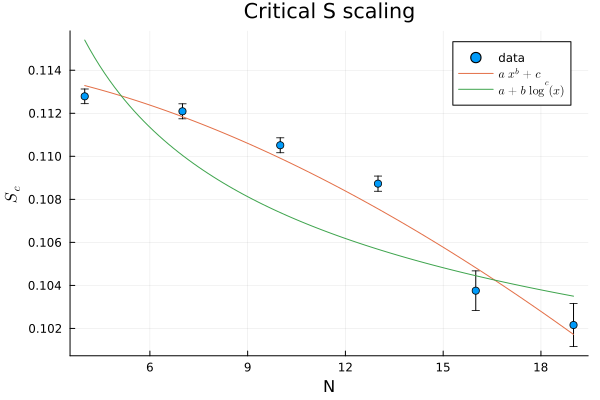

In [7]:
N = [4 + 3*(ns - 1) for ns in 1:ns_max]

x = LinRange(first(N), last(N), 100)

plt = plot(N, Sc[:, 1], yerr=Sc[:, 2], seriestype=:scatter, label="data")

fit = curve_fit(power_fit, N, Sc[:, 1], Sc[:, 2], [1., -2., 1.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, N, Sc[:, 1], Sc[:, 2], [-1., -1., -1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

xlabel!("N")
ylabel!(L"S_{c}")
title!("Critical S scaling")

savefig("row_s.pdf")
display(plt)

[0.0007628384470316765, 2.44045081183622, 7.83640875543307]
[7.8604597721177285, 0.0005894358566680328, 6.86510480641548]


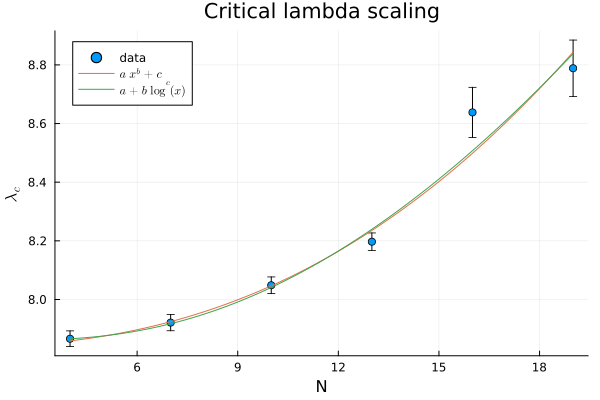

In [8]:
N = [4 + 3*(ns - 1) for ns in 1:ns_max]

lambda_c = (1 .- Sc[:, 1]) ./ Sc[:, 1]

wt = Sc[:, 1].^2 ./ Sc[:, 2]

x = LinRange(first(N), last(N), 100)

plt = plot(N, lambda_c, yerr=1 ./ wt, seriestype=:scatter, label="data")

fit = curve_fit(power_fit, N, lambda_c, wt, [1., 1., 1.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, N, lambda_c, wt, [1., 1., 1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

xlabel!("N")
ylabel!(L"\lambda_{c}")
title!("Critical lambda scaling")

savefig("row_lambda.pdf")
display(plt)

[0.10017555207317232, -0.7140082555273228, 0.011656348785856353]
[-0.03968527175859677, 0.10237402075649363, -0.4429998683899068]
[0.023341068170868413, 0.05747245487351529, -0.20425362753298837]
[2.7474931205760207, -0.730996954428763, 0.6267974351083461]


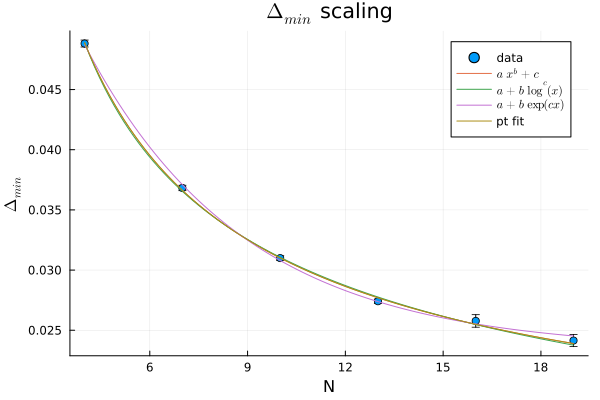

In [9]:
N = [4 + 3*(ns - 1) for ns in 1:ns_max]
wt = 1 ./ Dmin[:, 2]

x = LinRange(N[1], last(N), 100)

plt = plot(N, Dmin[:, 1], yerr=Dmin[:, 2], seriestype=:scatter, label="data")

fit = curve_fit(power_fit, N, Dmin[:, 1], wt, [0., -.7, 0.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, N, Dmin[:, 1], wt, [1., 1., 1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

fit = curve_fit(exp_fit, N, Dmin[:, 1], wt, [0., 0., -1.])
plot!(x, exp_fit(x, fit.param), label=L"a + b\ \exp(c x)")
println(fit.param)

th_fit(x, p) = (2 .* p[1] .* x.^p[2] .+ p[3]) ./ (52 .+ p[1] .* x.^p[2] .+ p[3])
fit = curve_fit(th_fit, N, Dmin[:, 1], wt, [0.5, -0.7, 0.2])
plot!(x, th_fit(x, fit.param), label="pt fit")
println(fit.param)

xlabel!("N")
ylabel!(L"\Delta_{min}")
title!(L"$\Delta_{min}$ scaling")

savefig("row_gap_N.pdf")
display(plt)

[1.5518964835735396e6, -8.496133987300617, 0.003913599273794904]
[5.710297443614726, -5.369866739770938, 0.07505047221410482]
[0.0202345819078065, 1.8298392785799385e10, -3.4756136146347343]


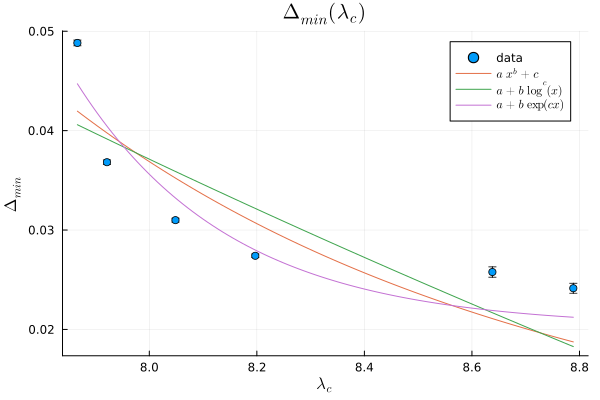

In [10]:
lambda_c = (1 .- Sc[:, 1]) ./ Sc[:, 1]

wt = Sc[:, 1].^2 ./ Sc[:, 2]

x = LinRange(first(lambda_c), last(lambda_c), 100)

plt = plot(lambda_c, Dmin[:, 1], yerr=Dmin[:, 2], seriestype=:scatter, label="data")

# power_fit(x, p) = p[1] .* (x .+ p[3]).^p[2]
fit = curve_fit(power_fit, lambda_c, Dmin[:, 1], wt, [0., -1., 0.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, lambda_c, Dmin[:, 1], wt, [1., -1., -1])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

fit = curve_fit(exp_fit, lambda_c, Dmin[:, 1], wt, [0., 1., -1.])
plot!(x, exp_fit(x, fit.param), label=L"a + b\ \exp(c x)")
println(fit.param)

xlabel!(L"\lambda_{c}")
ylabel!(L"\Delta_{min}")
title!(L"$\Delta_{min}(\lambda_{c})$")

savefig("row_gap_lambda.pdf")
display(plt)